# GPT architecture

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [12]:
import torch.nn as nn
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_block = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = DummyLayerNorm(cfg['emb_dim'])

        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )
    def forward(self, x):
        batch_size, seq_len = x.shape
        token_embeds = self.tok_emb(x)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = token_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x        
    

In [13]:
import tiktoken
import torch

tokenizer= tiktoken.get_encoding("gpt2")
batch=[]

batch.append(torch.tensor(tokenizer.encode("Every effort moves you")))
batch.append(torch.tensor(tokenizer.encode("Every day holds a")))
batch = torch.stack(batch, dim=0)

print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(cfg = GPT_CONFIG_124M)

logits = model(batch)
logits.shape ## (batch_size, seq_len, vocab_size)

torch.Size([2, 4, 50257])

## Normalizing with LayerNorm

In [15]:
torch.manual_seed(123)

batch_example = torch.randn(2,5)
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [16]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [30]:
mean = out.mean(dim=-1, keepdim=True)
mean

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)

In [31]:
var = out.var(dim=-1, keepdim=True)
var

tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)

In [35]:
torch.set_printoptions(sci_mode=False)

In [36]:
((out - mean)/var.sqrt()).mean(dim=-1)

tensor([-0.0000,  0.0000], grad_fn=<MeanBackward1>)

In [37]:
((out - mean)/var.sqrt()).var(dim=-1)

tensor([1.0000, 1.0000], grad_fn=<VarBackward0>)

We achieved normalized version of a layer output. But there is more to it than just that. 

In [38]:
class LayerNorm(nn.Module):
    def __init__(self, embed_dim, eps=1e-6):
        super().__init__()
        self.embed_dim = embed_dim
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(embed_dim))
        self.shift = nn.Parameter(torch.zeros(embed_dim)) ## essentially not adding anything But while training this might learn values to add
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        norm_x = (x - mean) / (std + self.eps)
        return self.scale * norm_x + self.shift

In [40]:
ln = LayerNorm(6)
norm_out = ln(out)

In [43]:
norm_out.mean(dim=-1)

tensor([-0.0000,  0.0000], grad_fn=<MeanBackward1>)

In [44]:
norm_out.var(dim=-1)

tensor([1.0000, 1.0000], grad_fn=<VarBackward0>)

## Feed Forward network with GELU activation
Gaussian error linear units (GELU)

![image.png](GELU.png)

In [47]:
import math
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            math.sqrt(2 / math.pi) * 
            (x + 0.044715 * torch.pow(x, 3))
            )
        )

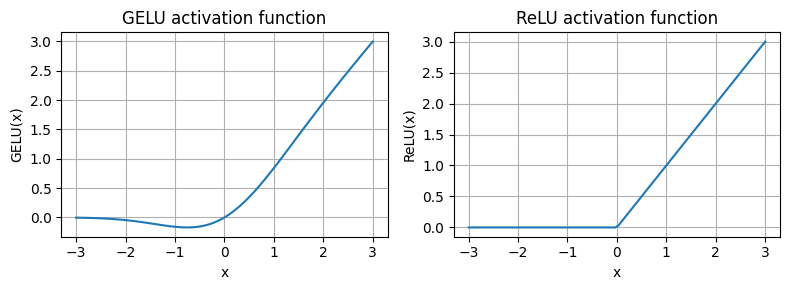

In [50]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [51]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']),
            GELU(),
            nn.Linear(4*cfg['emb_dim'], cfg['emb_dim'])
        )
    def forward(self, x):
        return self.layers(x)

In [54]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [62]:
class ExampleDeepNN(nn.Module):
    def __init__(self, layer_sizes, use_shortcuts=False):
        super().__init__()
        self.use_shortcuts = use_shortcuts
        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), nn.GELU()),
                nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), nn.GELU()),
                nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), nn.GELU()),    
                nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), nn.GELU()),
                nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), nn.GELU()),
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcuts and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [65]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [66]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNN(
    layer_sizes, use_shortcuts=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020174124801997095
layers.1.0.weight has gradient mean of 0.00012011774379061535
layers.2.0.weight has gradient mean of 0.0007152438047342002
layers.3.0.weight has gradient mean of 0.0013988513965159655
layers.4.0.weight has gradient mean of 0.005049603525549173


## Connecting attention and linear layers in a transformer block    

In [67]:
import torch.nn as nn

class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, dropout, context_length, bias=False):
        super().__init__()
        self.W_q = nn.Linear(d_in, d_out, bias=bias)
        self.W_k = nn.Linear(d_in, d_out, bias=bias)
        self.W_v = nn.Linear(d_in, d_out, bias=bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        Q = self.W_q(x) # (batch_size, num_tokens, d_out)
        K = self.W_k(x) # (batch_size, num_tokens, d_out)
        V = self.W_v(x) # (batch_size, num_tokens, d_out)
        d_k = K.shape[-1]
        
        attention_scores = Q @ K.transpose(1,2)
        attention_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
            -torch.inf
        )
    
        attention_weights = torch.softmax(attention_scores / d_k**0.5, dim=-1)
        context_vector = attention_weights @ V
        return context_vector

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [68]:
class Transformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x+shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x+shortcut

        return x

In [70]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = Transformer(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# Coding GPT Model
![image](GPT-arch.png)

In [ ]:
import torch.nn as nn
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim']) ## params are (d_in, d_out) BUT shape is (vocab_size, emb_dim)
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_block = nn.Sequential(
            *[Transformer(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['emb_dim'])

        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        ) ## size is (vocab_size, emb_dim) as W.T is used which requires size (emb_dim, vocab_size)
        ## the paramenters are defined as (d_in, d_out)
    def forward(self, x):
        batch_size, seq_len = x.shape
        token_embeds = self.tok_emb(x)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = token_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits  
    

In [80]:
torch.manual_seed(123)

In [81]:
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [82]:
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3612,  0.4223, -0.0709,  ...,  0.3479,  0.4655, -0.2833],
         [-0.1785, -0.5656, -0.9477,  ...,  0.0476,  0.5173, -0.3160],
         [ 0.7118,  0.0335,  0.1078,  ...,  0.1020, -0.4331, -0.2547],
         [-1.0068,  0.3420, -0.1191,  ...,  0.7193,  0.4018,  0.0532]],

        [[-0.2562,  0.0899,  0.0337,  ...,  0.2659,  0.4448, -0.6800],
         [ 0.1230,  0.3651, -0.2071,  ...,  0.7704,  0.2702,  0.2250],
         [ 1.0555,  1.0312, -0.2797,  ...,  0.6934,  0.3201, -0.3172],
         [-0.1559,  0.3922,  0.3286,  ...,  1.2627, -0.1862,  0.0391]]],
       grad_fn=<UnsafeViewBackward0>)


In [84]:
batch.numel()

8

In [83]:
total_params = sum(p.numel() for p in model.parameters())
total_params

163009536

This number does not correspond to 124M as it should coz in original architecture, there is some weight sharing going on. 



In [85]:
model.tok_emb.weight.shape

torch.Size([50257, 768])

In [86]:
model.out_head.weight.shape

torch.Size([50257, 768])

In [87]:
total_params - 50257*768

124412160

Since, the dimensions of embedding layer and output layer is the same, hence, that weight layer is shared

## Generating Text

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_length):
    for _ in range(max_new_tokens):
        ## first get the right context (truncate tokens outside context window)
        idx_cond = idx[:, -context_length:]

        ## pass it through the model
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :] ## getting the last row for the generated token
        
        ## apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)
        
        ## get index with max probability
        idx_next = torch.argmax(probas, dim=-1, keepdim = True)
        
        ## append the new token to the context
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [101]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
encoded

[15496, 11, 314, 716]

In [102]:
encoded_tensor = torch.tensor(encoded).unsqueeze(0)

In [ ]:
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_length = 1024
)

In [109]:
tokenizer.decode(out.squeeze(0).tolist())


'Hello, I am Feature IT snowball Terr Estate ar'